# Kaggle Imports and Setup

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
!kaggle competitions download -c birds23wi

mkdir: cannot create directory ‘/root/.kaggle’: File exists
birds23wi.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!apt-get install unzip
!unzip -q birds23wi.zip

In [ ]:
!pip install pandas
!pip install matplotlib

# Imports

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
from PIL import Image
from torch.optim import lr_scheduler
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

cuda:0
Fri Mar 10 07:20:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:81:00.0 Off |                  Off |
| 30%   32C    P8    29W / 450W |      2MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

# Hyperparameters

In [3]:
in_channel = 3
num_classes = 555
learning_rate = 1e-3
batch_size = 32
num_epochs = 15

# Import Data
We need to split some of the training data into validation data. We make a warpper Dataset class to help facilitate applying different transformations to the training data and validation data.

In [8]:
class BirdsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, str(self.annotations.iloc[index, 1]), self.annotations.iloc[index, 0])
        
        image = Image.open(img_path)
        image = image.convert("RGB") # some photos have the alpha channel
        
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)
    
class SplitDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
    
train_transform = transforms.Compose([
    transforms.RandomCrop(224, padding=16, padding_mode='edge'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = BirdsDataset(csv_file='/workspace/birds/labels.csv',
                       root_dir='/workspace/birds-resized/train',
                       transform=None)

train_subset, test_subset = torch.utils.data.random_split(dataset, [33562, 5000])

train_set = SplitDataset(train_subset, transform=train_transform)
test_set = SplitDataset(test_subset, transform=test_transform)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_loader.dataset), 'val': len(test_loader.dataset)}

print("Training set size: " + str(len(train_loader.dataset)))
print("Testing set size: " + str(len(test_loader.dataset)))

Training set size: 33562
Testing set size: 5000


# Visualize Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 518, 518])


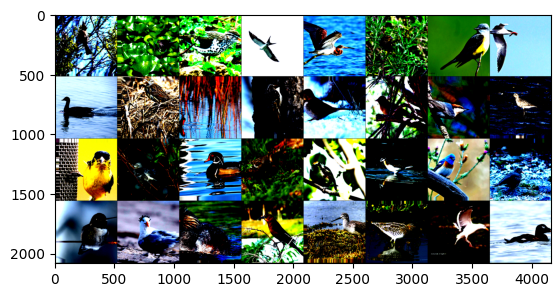

torch.Size([32, 3, 518, 518])
torch.Size([32, 804972])


In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print("Labels:" + ' '.join('%9s' % data['classes'][labels[j]] for j in range(8)))


flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

# Define the Model
We'll be using the resnet152 model for transfer learning!

In [5]:
# model = torchvision.models.resnet152(weights='ResNet152_Weights.DEFAULT').to(device)
model = torchvision.models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT').to(device)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

# Tweaking Model Parameters to Work with our Dataset

In [ ]:
# !kaggle datasets download rsslramos/resnet-bird-weights
!unzip -q resnet-bird-weights.zip

In [ ]:
print(model.classifier[1])

In [7]:
num_features = model.classifier[1].in_features 
model.classifier[1] = nn.Linear(num_features, 555) # Add our layer with 4 outputs

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# loss function
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# checkpoint = torch.load('/workspace/model_checkpoint.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = 25

# model.eval()
# - or -
model.train()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

# Define the Training Function

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



# Training!

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [10]:
model.train()
model = model.to(device)
model = train_model(model, criterion, optimizer, 
                    exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 5.1449 Acc: 0.1331
val Loss: 2.8316 Acc: 0.4956

Epoch 1/14
----------
train Loss: 2.2729 Acc: 0.5194
val Loss: 1.1910 Acc: 0.7328

Epoch 2/14
----------
train Loss: 1.3353 Acc: 0.6832
val Loss: 0.7842 Acc: 0.7998

Epoch 3/14
----------
train Loss: 0.9672 Acc: 0.7576
val Loss: 0.6170 Acc: 0.8362

Epoch 4/14
----------
train Loss: 0.7723 Acc: 0.8015
val Loss: 0.5320 Acc: 0.8520

Epoch 5/14
----------
train Loss: 0.6494 Acc: 0.8297
val Loss: 0.4755 Acc: 0.8634

Epoch 6/14
----------
train Loss: 0.5550 Acc: 0.8500
val Loss: 0.4409 Acc: 0.8702

Epoch 7/14
----------
train Loss: 0.4754 Acc: 0.8761
val Loss: 0.4262 Acc: 0.8748

Epoch 8/14
----------
train Loss: 0.4611 Acc: 0.8819
val Loss: 0.4131 Acc: 0.8796

Epoch 9/14
----------
train Loss: 0.4570 Acc: 0.8821
val Loss: 0.4079 Acc: 0.8792

Epoch 10/14
----------
train Loss: 0.4386 Acc: 0.8864
val Loss: 0.4115 Acc: 0.8824

Epoch 11/14
----------
train Loss: 0.4391 Acc: 0.8869
val Loss: 0.4001 Acc: 0.8822

Ep

KeyboardInterrupt: 

# OPTIONAL: Save Checkpoint

In [11]:
EPOCH = 3
PATH = "model_checkpoint_effnetv2.pt"
LOSS = 0.001
torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

# Save the Model Weights

In [ ]:
PATH = './model_weights.pth'
torch.save(model.state_dict(), PATH)

# Test the Model with Test Set

In [12]:
class TestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, str(self.annotations.iloc[index, 0])[5:])
        
        image = Image.open(img_path)
        image = image.convert("RGB") # some photos have the alpha channel
        
        y_label = torch.tensor(int(index))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)
    
test_dataset = TestDataset(csv_file='/workspace/birds/sample.csv',
                       root_dir='/workspace/birds-resized/test/',
                       transform=test_transform)

testing_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print("Testing set size: " + str(len(testing_loader.dataset)))

Testing set size: 10000


In [13]:
df = pd.DataFrame([], [], columns=['label', 'pred'])
model.eval()
with torch.no_grad():
    for inputs, labels in testing_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        pred = torch.argmax(outputs, 1)
        
        df2 = pd.DataFrame({'label': labels.cpu().numpy(), 'pred': pred.cpu().numpy()})
        df = pd.concat([df, df2], ignore_index=True)

        # print(data['pred'])
        # print(labels.cpu().numpy())

print(len(df))

10000


# Create the Final .csv

In [14]:
print(df)

     label pred
0        0  305
1        1  227
2        2   70
3        3  362
4        4   40
...    ...  ...
9995  9995  368
9996  9996  218
9997  9997   42
9998  9998   36
9999  9999  215

[10000 rows x 2 columns]


In [15]:
test_csv = pd.read_csv("/workspace/birds/sample.csv")
res_csv = pd.DataFrame(columns=['path', 'class'])
for i in range(10000):
    new_row = pd.DataFrame({'path': [test_csv.iloc[i, 0]], 'class': [df.iloc[i, 1]]})
    res_csv = pd.concat([res_csv, new_row], ignore_index=True)

print(res_csv)

                                           path class
0     test/ccd7fe22b2214123aa5c7501653741e8.jpg   305
1     test/ae8d11baa5104860809d79ff626f7286.jpg   227
2     test/374ff1843b4c4b32b8f4145ae17bace0.jpg    70
3     test/df7f4ed304f6496c9dbf6350552b4858.jpg   362
4     test/ba883a3b5b34446093dc98889b957258.jpg    40
...                                         ...   ...
9995  test/8e9ac4ac8d2940b182eb4f0e29e263b7.jpg   368
9996  test/08ddc93924674259b7a318693369bd86.jpg   218
9997  test/0f6d51c0a36b4251be04d3aa83bb4b3d.jpg    42
9998  test/0e9d318a8738401090060740ef5182ea.jpg    36
9999  test/852dbbe3a24841979abb7d31e8823897.jpg   215

[10000 rows x 2 columns]


In [16]:
compression_opts = dict(method='zip',
                        archive_name='out.csv') 
res_csv.to_csv('out.zip', index=False,
          compression=compression_opts)